In [ ]:
!pip install pandas numpy
!pip install uproot==5.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.7/375.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 34.6 MB/s eta 0:00:00


In [ ]:
import uproot
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/My Drive/step2_OpenData_0001.root"

file = uproot.open(file_path)
tree = file["Events"]

branches = tree.keys()
print("\nAvailable branches in the TTree:")
for branch in branches:
    print(f"- {branch}")

tracker_vars = ["x", "y", "z", "charge", "hit", "track", "rechit", "active", "mask"]
calorimeter_vars = ["ecal", "hcal", "energy", "eta", "phi"]

def check_relevant_branches(branches, tracker_vars, calorimeter_vars):
    print("\nChecking for tracker-related branches:")
    tracker_found = [b for b in branches if any(var.lower() in b.lower() for var in tracker_vars)]
    for branch in tracker_found:
        print(f"- {branch}")
    if not tracker_found:
        print("No obvious tracker branches found.")

    print("\nChecking for calorimeter-related branches:")
    calorimeter_found = [b for b in branches if any(var.lower() in b.lower() for var in calorimeter_vars)]
    for branch in calorimeter_found:
        print(f"- {branch}")
    if not calorimeter_found:
        print("No obvious calorimeter branches found.")

check_relevant_branches(branches, tracker_vars, calorimeter_vars)

# print("\nSample data (first 10 events) for potential branches:")
# sample_branches = [b for b in branches if any(var.lower() in b.lower() for var in tracker_vars + calorimeter_vars)]
# if sample_branches:
#     data = tree.arrays(sample_branches, entry_stop=10)
#     df = pd.DataFrame(data)
#     print("\nSample data preview:")
#     print(df.head())
# else:
#     print("No relevant branches selected for sampling.")

file.close()


In [ ]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/My Drive/step2_OpenData_0001.root"
file = uproot.open(file_path)
tree = file["Events"]

tracker_branches = [
    "recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fX",
    "recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fY",
    "recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fZ",
    "recoTracks_generalTracks__RECO./recoTracks_generalTracks__RECO.obj/recoTracks_generalTracks__RECO.obj.charge_",
    "recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerOk_"
]

branches = tree.keys()
missing = [b for b in tracker_branches if b not in branches]
if missing:
    print("Missing branches:", missing)
    exit(1)

print("\nChecking branch structure:")
for branch in tracker_branches:
    arr = tree[branch].array(entry_stop=10)
    print(f"- {branch}: {type(arr)}, {arr[:2]}")

data = tree.arrays(tracker_branches, entry_stop=1000)

vertices_list = []

for i in range(len(data)):
    x = data[tracker_branches[0]][i]
    y = data[tracker_branches[1]][i]
    z = data[tracker_branches[2]][i]
    charge = data[tracker_branches[3]][i]
    active = data[tracker_branches[4]][i]

    n = min(len(x), len(y), len(z), len(charge), len(active))
    x, y, z, charge, active = x[:n], y[:n], z[:n], charge[:n], active[:n]

    x = x[active]
    y = y[active]
    z = z[active]
    charge = charge[active]

    for j in range(len(x)):
        vertices_list.append({
            "event": i,
            "x": float(x[j]),
            "y": float(y[j]),
            "z": float(z[j]),
            "charge": int(charge[j]),
            "active": bool(active[j])
        })

vertices = pd.DataFrame(vertices_list)
vertices = vertices.dropna()

output_file = "/content/drive/My Drive/tracker_vertices.csv"
vertices.to_csv(output_file, index=False)
print("\nSaved to:", output_file)

print("\nSample:")
print(vertices.head())

print("\nRanges:")
print("x:", vertices["x"].min(), "to", vertices["x"].max())
print("y:", vertices["y"].min(), "to", vertices["y"].max())
print("z:", vertices["z"].min(), "to", vertices["z"].max())
print("charge:", np.unique(vertices["charge"]))
print("active:", np.unique(vertices["active"]))

file.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Checking branch structure:
- recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fX: <class 'awkward.highlevel.Array'>, [[-4.21, -4.18, -4.66, -4.21, -4.65, ..., -23.6, -49.5, 27.6, 7.86, 23.1], ...]
- recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fY: <class 'awkward.highlevel.Array'>, [[-0.0193, 0.128, -0.148, -0.0199, -0.182, ..., -31.8, 26.5, 31.2, -58.8], ...]
- recoTrackExtras_generalTracks__RECO./recoTrackExtras_generalTracks__RECO.obj/recoTrackExtras_generalTracks__RECO.obj.innerPosition_.fCoordinates.fZ: <class 'awkward.highlevel.Array'>, [[-1.25, -5.25, 1.13, 12.1, -5.76, ..., 106, -144, -110, -106, -176], ...]
- recoTracks_generalTracks__RECO./recoTracks_gener

In [ ]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/My Drive/step2_OpenData_0001.root"
file = uproot.open(file_path)
tree = file["Events"]

calorimeter_branches = [
    "EcalRecHitsSorted_reducedEcalRecHitsEB__RECO./EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj.energy_",
    "EcalRecHitsSorted_reducedEcalRecHitsEB__RECO./EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj.id_.id_",
    "EcalRecHitsSorted_reducedEcalRecHitsEE__RECO./EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj.obj.energy_",
    "EcalRecHitsSorted_reducedEcalRecHitsEE__RECO./EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj.obj.id_.id_",
    "HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO./HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj/HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj.obj/HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj.obj.energy_",
    "HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO./HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj/HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj.obj/HBHERecHitsSorted_reducedHcalRecHits_hbhereco_RECO.obj.obj.id_.id_"
]

branches = tree.keys()
missing = [b for b in calorimeter_branches if b not in branches]
if missing:
    print("Missing branches:", missing)
    for b in branches:
        if any(x in b for x in ["EcalRecHits", "HBHERecHits"]):
            print("-", b)
    exit(1)

print("\nChecking branch structure:")
for b in calorimeter_branches:
    arr = tree[b].array(entry_stop=10)
    print(f"- {b}: {type(arr)}, {arr[:2]}")

def ecal_id_to_eta_phi(det_id):
    ieta = ((det_id >> 7) & 0x1FF)
    if ieta > 85:
        ieta -= 170
    iphi = (det_id & 0x1FF) % 360 + 1
    eta = ieta * 0.0174
    phi = (iphi - 0.5) * 2 * np.pi / 360
    return eta, np.arctan2(np.sin(phi), np.cos(phi))

def hcal_id_to_eta_phi(det_id):
    ieta = ((det_id >> 7) & 0x7F)
    if ieta > 29:
        ieta -= 58
    iphi = (det_id & 0x7F) % 72 + 1
    eta = ieta * 0.087
    phi = (iphi - 0.5) * 2 * np.pi / 72
    return eta, np.arctan2(np.sin(phi), np.cos(phi))

data = tree.arrays(calorimeter_branches, entry_stop=1000)

vertices_list = []

for i in range(len(data)):
    eb_e, eb_id = data[calorimeter_branches[0]][i], data[calorimeter_branches[1]][i]
    ee_e, ee_id = data[calorimeter_branches[2]][i], data[calorimeter_branches[3]][i]
    hc_e, hc_id = data[calorimeter_branches[4]][i], data[calorimeter_branches[5]][i]

    eb_n = min(len(eb_e), len(eb_id))
    ee_n = min(len(ee_e), len(ee_id))
    hc_n = min(len(hc_e), len(hc_id))

    eb_e, eb_id = eb_e[:eb_n], eb_id[:eb_n]
    ee_e, ee_id = ee_e[:ee_n], ee_id[:ee_n]
    hc_e, hc_id = hc_e[:hc_n], hc_id[:hc_n]

    eb_mask = eb_e > 0.01
    ee_mask = ee_e > 0.01
    hc_mask = hc_e > 0.01

    eb_e, eb_id = eb_e[eb_mask], eb_id[eb_mask]
    ee_e, ee_id = ee_e[ee_mask], ee_id[ee_mask]
    hc_e, hc_id = hc_e[hc_mask], hc_id[hc_mask]

    for j in range(len(eb_e)):
        eta, phi = ecal_id_to_eta_phi(eb_id[j])
        if abs(eta) <= 2.5:
            vertices_list.append({"event": i, "type": "ECAL_BARREL", "eta": eta, "phi": phi, "energy": eb_e[j], "active": True})

    for j in range(len(ee_e)):
        eta, phi = ecal_id_to_eta_phi(ee_id[j])
        if 1.5 <= abs(eta) <= 3.0:
            vertices_list.append({"event": i, "type": "ECAL_ENDCAP", "eta": eta, "phi": phi, "energy": ee_e[j], "active": True})

    for j in range(len(hc_e)):
        eta, phi = hcal_id_to_eta_phi(hc_id[j])
        if abs(eta) <= 3.0:
            vertices_list.append({"event": i, "type": "HCAL", "eta": eta, "phi": phi, "energy": hc_e[j], "active": True})

vertices = pd.DataFrame(vertices_list)
vertices = vertices.dropna()

output_file = "/content/drive/My Drive/calorimeter_vertices.csv"
vertices.to_csv(output_file, index=False)
print("\nSaved to:", output_file)

print("\nSample:")
print(vertices.head())

print("\nRanges:")
for cal_type in ["ECAL_BARREL", "ECAL_ENDCAP", "HCAL"]:
    subset = vertices[vertices["type"] == cal_type]
    if not subset.empty:
        print(f"{cal_type}:")
        print("  eta:", round(subset["eta"].min(), 2), "to", round(subset["eta"].max(), 2))
        print("  phi:", round(subset["phi"].min(), 2), "to", round(subset["phi"].max(), 2))
        print("  energy:", round(subset["energy"].min(), 2), "to", round(subset["energy"].max(), 2))

print("active:", np.unique(vertices["active"]))
print("types:", np.unique(vertices["type"]))

file.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Checking branch structure:
- EcalRecHitsSorted_reducedEcalRecHitsEB__RECO./EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj.energy_: <class 'awkward.highlevel.Array'>, [[0.0903, 0.0421, 0.0299, 0.087, -0.0021, ..., 0.14, 0.261, 0.0868, 0.12], ...]
- EcalRecHitsSorted_reducedEcalRecHitsEB__RECO./EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEB__RECO.obj.obj.id_.id_: <class 'awkward.highlevel.Array'>, [[838861431, 838861449, 838861450, ..., 838970160, 838970164, 838970211], ...]
- EcalRecHitsSorted_reducedEcalRecHitsEE__RECO./EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__RECO.obj.obj/EcalRecHitsSorted_reducedEcalRecHitsEE__

/tmp/ipython-input-5-3885223449.py:39: RuntimeWarning: overflow encountered in scalar subtract
  ieta -= 170



Saved to: /content/drive/My Drive/calorimeter_vertices.csv

Sample:
   event         type     eta       phi    energy  active
0      0  ECAL_BARREL  0.0696  2.085668  0.090321    True
1      0  ECAL_BARREL  0.0870  2.399828  0.042109    True
2      0  ECAL_BARREL  0.0870  2.417281  0.029940    True
3      0  ECAL_BARREL  0.0870  2.434734  0.086986    True
4      0  ECAL_BARREL  0.0870  2.487094  0.017153    True

Ranges:
ECAL_BARREL:
  eta: 0.0 to 2.49
  phi: -3.13 to 3.13
  energy: 0.01 to 312.75
HCAL:
  eta: 0.09 to 2.96
  phi: -3.1 to 3.1
  energy: 0.01 to 392.77
active: [ True]
types: ['ECAL_BARREL' 'HCAL']


In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files

# Step 1: Specify the path to your Parquet file
file_path = '/content/BoostedTop_x1_fixed_0.snappy.parquet'  # Update if needed

# Step 2: Read the Parquet file
try:
    df = pd.read_parquet(file_path, engine='pyarrow')
except Exception as e:
    print(f"Error loading Parquet file: {e}")
    raise

print("\n=== Dataset Overview ===")
print(f"Shape of dataset: {df.shape}")
print(f"Shape of X_jets[0]: {df['X_jets'][0].shape}")
print("\nColumns in dataset:")
print(df.columns.tolist())

numerical_cols = ['y', 'm0', 'pt']
print("\n=== Summary Statistics for Numerical Columns ===")
print(df[numerical_cols].describe())

print("\n=== Sample Data (First 5 Rows, Excluding X_jets) ===")
print(df[numerical_cols + ['X_jets']].head())


sample_jet = df['X_jets'][0]
num_elements = sample_jet.size
print(f"Number of elements in X_jets[0]: {num_elements}")
print(f"Data type of X_jets[0]: {sample_jet.dtype}")
print(f"Minimum value: {np.min(sample_jet)}")
print(f"Maximum value: {np.max(sample_jet)}")
print(f"Mean value: {np.mean(sample_jet)}")
print(f"Number of zero elements: {(sample_jet == 0).sum()}")
print(f"Number of non-zero elements: {(sample_jet != 0).sum()}")




=== Dataset Overview ===
Shape of dataset: (3200, 4)
Shape of X_jets[0]: (125000,)

Columns in dataset:
['X_jets', 'y', 'm0', 'pt']

=== Summary Statistics for Numerical Columns ===
                 y           m0           pt
count  3200.000000  3200.000000  3200.000000
mean      0.221562   124.183773   521.334680
std       0.415363    45.842169   112.011281
min       0.000000    35.933876   400.025055
25%       0.000000    90.219893   443.030983
50%       0.000000   113.564911   490.268311
75%       0.000000   153.681465   565.242447
max       1.000000   454.155457  1631.924927

=== Sample Data (First 5 Rows, Excluding X_jets) ===
     y          m0          pt  \
0  1.0  181.342728  491.635803   
1  0.0  159.301620  757.597900   
2  0.0   93.660439  682.969482   
3  0.0  202.057114  765.743225   
4  0.0  157.177841  505.105835   

                                              X_jets  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Data loaded!
Found 2453 hits


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


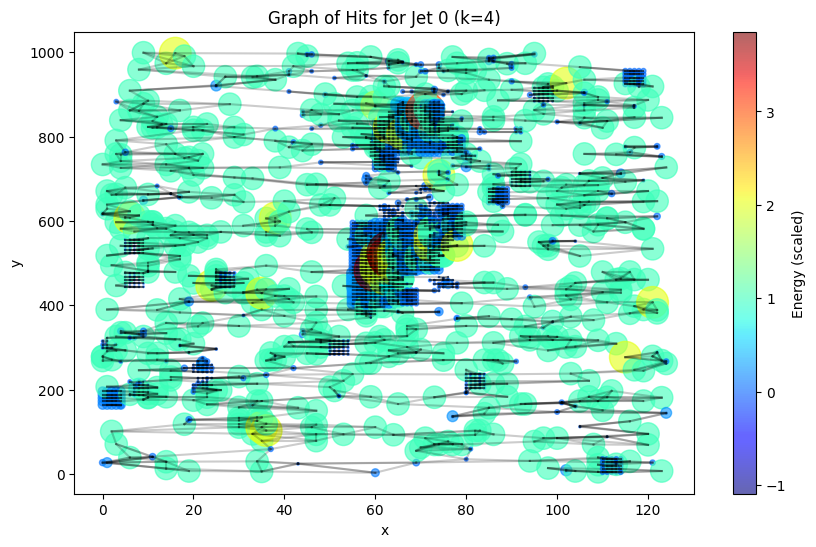

Found 2325 hits


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


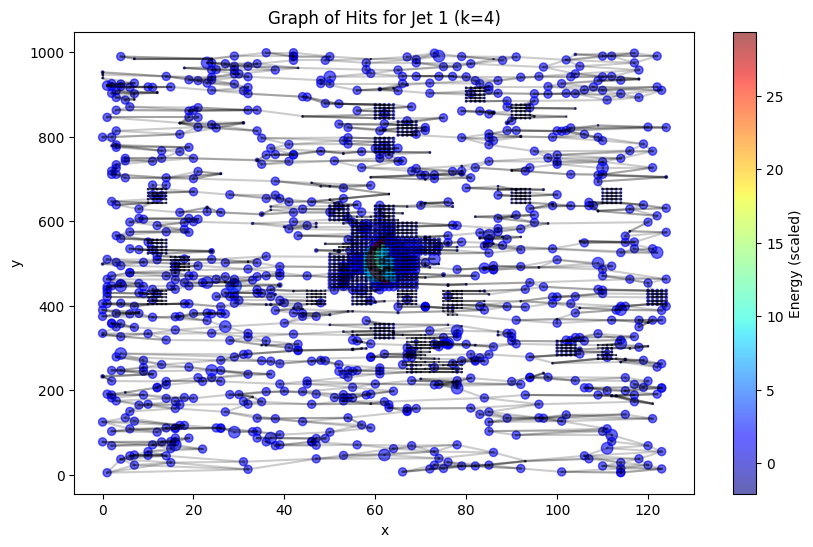

Found 1722 hits


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


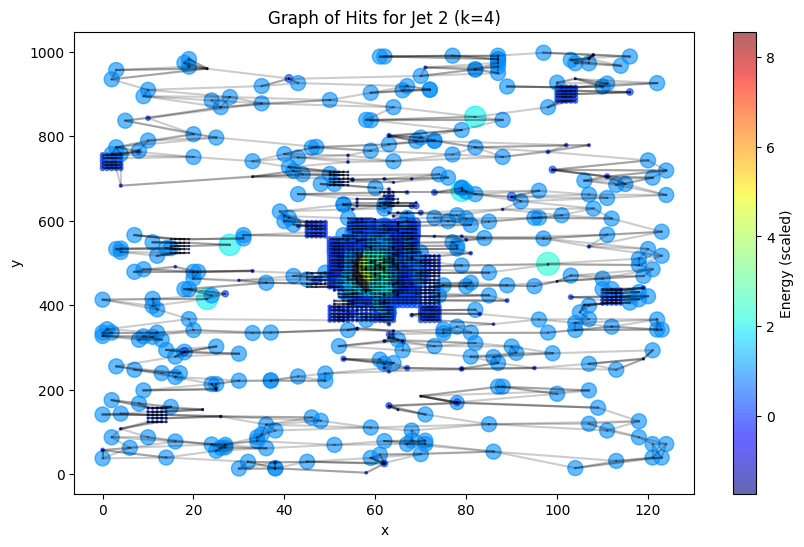

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt

# Load data
file_path = '/content/BoostedTop_x1_fixed_0.snappy.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')
print("Data loaded!")

# Reshape X_jets
jets = [df['X_jets'][0], df['X_jets'][1], df['X_jets'][2]]
reshaped_jets = []
for jet in jets:
    num_elements = jet.size
    reshaped = jet.reshape((125,1000))

    if reshaped is None:
        reshaped = jet
    reshaped_jets.append(reshaped)

# Function to get non-zero hits
def get_hits(jet_array):
    if len(jet_array.shape) == 2:
        indices = np.nonzero(jet_array)
        x = indices[0]
        y = indices[1]
        energy = jet_array[indices]
        hits = np.vstack((x, y, energy)).T
        print(f"Found {len(hits)} hits")
        return hits
    return None

# Function to create graph
def make_graph(hits):
    if hits is None or len(hits) == 0:
        return None, None
    coords = hits[:, :2]
    adj_matrix = kneighbors_graph(coords, n_neighbors=4, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(adj_matrix)
    return G, hits

# Create and show graphs for each jet
for i, jet in enumerate(reshaped_jets):
    hits = get_hits(jet)
    if hits is None:
        print(f"No hits for jet {i}")
        continue
    G, hits = make_graph(hits)
    if G is None:
        print(f"No graph for jet {i}")
        continue

    plt.figure(figsize=(10, 6))
    x = hits[:, 0]
    y = hits[:, 1]
    energy = hits[:, 2]
    plt.scatter(x, y, s=energy * 1000 / (energy.max() + 1e-10), c=energy, cmap='jet', alpha=0.6)

    for edge in G.edges():
        x_edge = [hits[edge[0], 0], hits[edge[1], 0]]
        y_edge = [hits[edge[0], 1], hits[edge[1], 1]]
        plt.plot(x_edge, y_edge, 'k-', alpha=0.2)

    plt.title(f'Graph of Hits for Jet {i} (k=4)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='Energy (scaled)')
    plt.show()